# Excel Agents
This notebook will walk you through the steps to run a multi-agent workflow that parses information in different cells and uses a number of LLM api calls in proper sequence to convert an engineering calcuation excel spreadsheet into a well-documented python code. 


### Define a spreadsheet
Start by specifying the path to your excel spreadsheet as follows. The AI-generated content will be stored in the same directory. You can also use the follwoing default example in the repo:

In [1]:
spreadsheet_name = 'simple_beam'
path = f"examples/simple_beam/{spreadsheet_name}.xlsx"

There are two main classes that allow us to orchestrate the agentic work flow. 
1. `ExcelVariableAgent`: This class will preprocess an existing Excel spreadsheet, creates a database and dispatches a swarm of agents to study the contents of cells, create variable names for our python scriot and make small python code blocks for the contents of cells. 

2. `ProgrammerAgent`: Once the ExcelVariableAgent workers have finished creating a processed database of cell information, Programmer will start refactoring the python code blocks, scafolling a python codebase and finally creating an example script to test the codebase. 

## Part 1: ExcelVariableAgent

In [2]:
from llm_agents.cell_inspectors import ExcelVariableAgent

Create an instance of the variable agent. Running the following cell will start extracting useful information from each cell, including the content, formulas, dependents, ....

In [3]:
variable_agent = ExcelVariableAgent(
                 spread_sheet_path =path,
                 openai_model = "gpt-4.1-mini",
                 trace_with_langfuse = True)

For example, we can look at the contents of one of the cells using the following lines: 

In [6]:
cell_data = variable_agent.db.get_cell_data("E19", "calcs")
cell_data

{'row': 18,
 'column': 4,
 'sheet': 'calcs',
 'value': {'raw': 105, 'type': 'int'},
 'formatted_value': '105',
 'alias': None,
 'value_list': [],
 'formula': '=P*D3/4+(D5*D6/1000)*D3^2/8',
 'data_type': 'int',
 'cell_type': 'formula',
 'precedent_cells': [{'cell_ref': 'D3',
   'sheet_name': 'calcs',
   'workbook_name': 'simple_beam.xlsx'},
  {'cell_ref': 'D5',
   'sheet_name': 'calcs',
   'workbook_name': 'simple_beam.xlsx'},
  {'cell_ref': 'D6',
   'sheet_name': 'calcs',
   'workbook_name': 'simple_beam.xlsx'},
  {'cell_ref': 'D4',
   'sheet_name': 'calcs',
   'workbook_name': 'simple_beam.xlsx'}],
 'dependent_cells': [{'cell_ref': 'L9',
   'sheet_name': 'calcs',
   'workbook_name': 'simple_beam.xlsx'}],
 'metadata': {'style': {'number_format': 'General',
   'font': {'name': 'Aptos Narrow',
    'size': 12.0,
    'bold': False,
    'italic': False},
   'fill': {'type': None, 'bg_color': '00000000'},
   'alignment': {'horizontal': None, 'vertical': None}}}}

As mentioned earlier, `variable_agent` will create a computational graph and starts processing cells from input root nodes to the output leaf nodes as shown in the following graph:

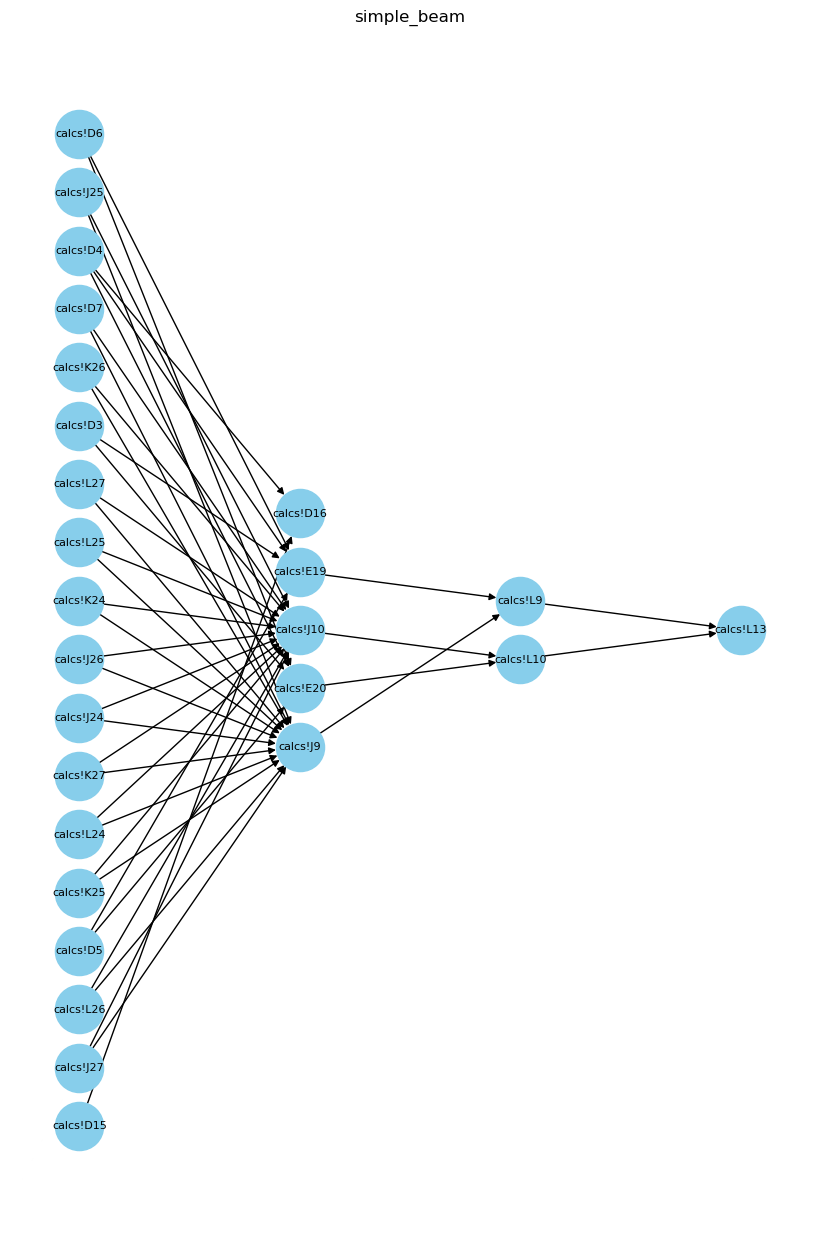

In [4]:
variable_agent.graph.visualize(
        figsize=(8, 12),
    node_size=1200,
    title=spreadsheet_name,
    save_path=f"{variable_agent.project_dir}/computegraph_{spreadsheet_name}.png"
)

Now, with all the preprocessing out of the way, we can dipatch the army of LLMs to start inspeting cells. For each layer, we call all nodes simultaneously using the asyc functionailty in python.

💸⚠️ Note that running the following cell will cost you money. There will be an API call for every node of your compute graph. If you don't want to make api calls, you can skip running the following cell as the programmer agent will load `variable_db_simple_beam.pkl` for this specific example from the project directory. 

In [5]:
await variable_agent.orchestrate_variable_extraction()

processing layer 0 with 18 cells
processing layer 1 with 5 cells
processing layer 2 with 2 cells
processing layer 3 with 1 cells


Once the agentic process is finished, we can print the contents of our variable database that contains:
* variable names
* variable descriptions
* python code blocks

In [6]:
for k,v in variable_agent.variable_db.items():
    sheet,cell = k
    print(sheet,cell)
    var_name = v['variable_name']
    variable_desr = v['variable_desr']
    python_code = v['python_code']
    print(f"var name: {var_name}")
    print(f"var desc: {variable_desr}")
    print(f"python code:\n`{python_code}`")
    print("-"*100)

calcs D3
var name: beam_length_ft
var desc: length of the beam in feet
python code:
`beam_length_ft = 20`
----------------------------------------------------------------------------------------------------
calcs D4
var name: P_kip
var desc: mid span point load in kips
python code:
`P_kip = 15`
----------------------------------------------------------------------------------------------------
calcs D5
var name: area_load_q
var desc: area load in pounds per square foot (psf)
python code:
`area_load_q = 30`
----------------------------------------------------------------------------------------------------
calcs D6
var name: trib_width_ft
var desc: tributary width in feet
python code:
`trib_width_ft = 20`
----------------------------------------------------------------------------------------------------
calcs D7
var name: section
var desc: Section type of the beam, which can be one of the finite set values: alpha, bravo, charlie, delta
python code:
`section = 'delta'  # example value, 

## Part 2: ProgrammerAgent
While we created some code blocks for the contets of each cell in the previous part, the code blocks are not connected to form a complete and end to end graph. We collect the previous code blocks and present them to an object of the `ProgrammerAgent` to generate a higher quality code base for us.

In [7]:
from llm_agents.programmer import ProgrammerAgent

In [8]:
programmer = ProgrammerAgent(
    spread_sheet_path=path,
    openai_model="gpt-4.1",
    trace_with_langfuse=True
)

After initialization, we can run our agent to creat our code base. `ProgrammerAgent` can create directories and save code as .py files. 


💸⚠️ Running the following cell will also cost you money. Feel free to skip it and directly go to the spreadsheet directory to look at the AI generated content. 


In [ ]:
messages = await programmer.initialize_coding_agent()

## Testing the final result
Go to the spreadsheet project directory, and review the code! You will see that our LLM even created a readme file to document the project. Additionally, you can run the example.py generated by the LLM to test how it did. For this specific example, it is recommended to use a larger top-tier LLM with better reasonining capabilites. 